<a href="https://colab.research.google.com/github/s-pike3/Projects_In_AI-ML/blob/main/HW5_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

Projects in AI & ML HW5 Part 2 \\
Sarah Pike


Link to the dataset: https://www.kaggle.com/datasets/alessiocorrado99/animals10

In [1]:
import numpy as np
from torch.utils.data.dataloader import default_collate
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from sklearn.preprocessing import LabelBinarizer
!pip install torcheval
from torcheval.metrics import MulticlassAccuracy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.9 MB/s eta 0:00:00


### Setup

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

100%|██████████| 586M/586M [00:07<00:00, 82.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [34]:
from torchvision import datasets, transforms

data_dir = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img"
# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to a uniform size
    transforms.ToTensor()          # Convert images to tensors
])

# Load the dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

Train-Val-Test Split

In [4]:
from torch.utils.data import random_split
generator1 = torch.Generator().manual_seed(42)
trainset,valset,testset = random_split(dataset, [int(len(dataset)*0.8)+1, int(len(dataset)*0.1)+1,int(len(dataset)*0.1)], generator=generator1)

In [5]:
batch_size = 8

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

### VAE

Implementation from:  https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [75]:
# From https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
class Encoder(nn.Module):

    def __init__(self, input_dim=3*1024, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        #print("enc")
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var

In [86]:
# From https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
class Decoder(nn.Module):

    def __init__(self, output_dim=3*1024, hidden_dim=512, latent_dim=256):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        #print("dec")
        x = self.LeakyReLU(self.linear2(x))
        #print("dec2")
        x = self.LeakyReLU(self.linear1(x))

        x_hat = torch.sigmoid(self.output(x))
        return x_hat

In [85]:
# From https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
class VAE(nn.Module):

    def __init__(self, input_dim=3*1024, hidden_dim=400, latent_dim=200):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [48]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [76]:
# From https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
def loss_function(x, x_hat, mean, log_var):
    #print(x)
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

#### Training

In [78]:
def train(model, optimizer, epochs,  x_dim=1024*3):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(trainloader):
            x = x.view(batch_size, x_dim)

            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [104]:
train(model, optimizer, epochs=50)

	Epoch 1 	Average Loss:  1926.0519721935302
	Epoch 2 	Average Loss:  1925.6331074371747
	Epoch 3 	Average Loss:  1924.9428492638278
	Epoch 4 	Average Loss:  1924.4748041650746
	Epoch 5 	Average Loss:  1924.0023967668578
	Epoch 6 	Average Loss:  1923.5331346033
	Epoch 7 	Average Loss:  1923.3150599781775
	Epoch 8 	Average Loss:  1922.9794918143389
	Epoch 9 	Average Loss:  1922.335064582985
	Epoch 10 	Average Loss:  1921.9063561643222
	Epoch 11 	Average Loss:  1921.6294973371228
	Epoch 12 	Average Loss:  1921.5154256387025
	Epoch 13 	Average Loss:  1921.3740296413027
	Epoch 14 	Average Loss:  1921.429925670048
	Epoch 15 	Average Loss:  1921.5504646694837
	Epoch 16 	Average Loss:  1920.4853374290249
	Epoch 17 	Average Loss:  1920.4179460338203
	Epoch 18 	Average Loss:  1920.267755189924
	Epoch 19 	Average Loss:  1920.422708921684
	Epoch 20 	Average Loss:  1920.2485540008836
	Epoch 21 	Average Loss:  1919.821285190954
	Epoch 22 	Average Loss:  1920.4793280899228
	Epoch 23 	Average Loss:  1

40150494.2734375

#### Reconstruction

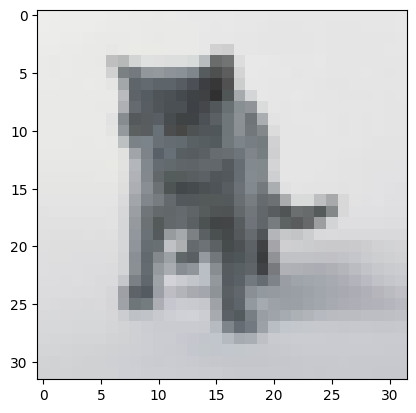

In [112]:
#Original image in reduced dimension
image, label = dataset[15000]

image_np = image.permute(1, 2, 0).numpy()

# Display the image using Matplotlib
plt.imshow(image_np)
plt.show()

In [116]:
gen_img = model(image.reshape(1,3*1024))

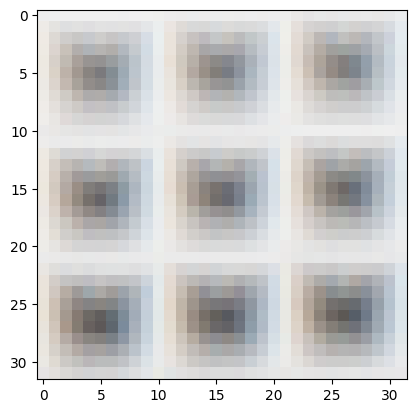

In [127]:
#reconstructed image
img = gen_img[0].detach().reshape(3)
plt.imshow(img)

### GAN
Implementation from: https://medium.com/@theprogramminggeek/generating-new-realities-crafting-a-simple-gan-with-pytorch-fc312f57a12d

In [35]:
# From https://medium.com/@theprogramminggeek/generating-new-realities-crafting-a-simple-gan-with-pytorch-fc312f57a12d
latent_dim = 100  # Size of the random noise vector

# Define the Generator's architecture
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.Linear(1024, 32*32*3),
    nn.Tanh()
)

In [24]:
# From https://medium.com/@theprogramminggeek/generating-new-realities-crafting-a-simple-gan-with-pytorch-fc312f57a12d
# Define the Discriminator's architecture
D = nn.Sequential(
    nn.Linear(32*32*3, 1024),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [30]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [31]:
# # From https://medium.com/@theprogramminggeek/generating-new-realities-crafting-a-simple-gan-with-pytorch-fc312f57a12d
import torch.autograd as autograd

# Number of epochs
num_epochs = 15

# Training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(trainloader):
        # Flatten the images for the Discriminator
        images = images.view(images.size(0), -1)

        # Real labels are 1, fake labels are 0
        real_labels = torch.ones(images.size(0), 1)
        fake_labels = torch.zeros(images.size(0), 1)


        # Train the Discriminator
        D_optimizer.zero_grad()

        # Compute BCELoss using real images
        outputs = D(images)
        D_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Generate fake images
        z = torch.randn(images.size(0), latent_dim)
        fake_images = G(z)

        # Compute BCELoss using fake images
        outputs = D(fake_images.detach())
        D_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Optimize the Discriminator
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optimizer.step()

        # Train the Generator
        G_optimizer.zero_grad()

        # Generate fake images
        z = torch.randn(images.size(0), latent_dim)
        fake_images = G(z)

        # Compute BCELoss using fake images, with reversed labels
        outputs = D(fake_images)
        G_loss = criterion(outputs, real_labels)

        # Optimize the Generator
        G_loss.backward()
        G_optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], D_loss: {:.4f}, G_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch+1, num_epochs, i+1, len(trainloader), D_loss.item(), G_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

Epoch [1/15], Step [100/2618], D_loss: 1.3270, G_loss: 0.7420, D(x): 0.48, D(G(z)): 0.45
Epoch [1/15], Step [200/2618], D_loss: 1.3395, G_loss: 0.7996, D(x): 0.48, D(G(z)): 0.45
Epoch [1/15], Step [300/2618], D_loss: 1.4247, G_loss: 0.6879, D(x): 0.51, D(G(z)): 0.53
Epoch [1/15], Step [400/2618], D_loss: 1.3420, G_loss: 0.7607, D(x): 0.49, D(G(z)): 0.46
Epoch [1/15], Step [500/2618], D_loss: 1.4351, G_loss: 0.7477, D(x): 0.48, D(G(z)): 0.50
Epoch [1/15], Step [600/2618], D_loss: 1.2792, G_loss: 0.7031, D(x): 0.56, D(G(z)): 0.51
Epoch [1/15], Step [700/2618], D_loss: 1.5169, G_loss: 0.6774, D(x): 0.48, D(G(z)): 0.54
Epoch [1/15], Step [800/2618], D_loss: 1.4468, G_loss: 0.6710, D(x): 0.48, D(G(z)): 0.50
Epoch [1/15], Step [900/2618], D_loss: 1.4607, G_loss: 0.7738, D(x): 0.47, D(G(z)): 0.50
Epoch [1/15], Step [1000/2618], D_loss: 1.4402, G_loss: 0.5968, D(x): 0.55, D(G(z)): 0.57
Epoch [1/15], Step [1100/2618], D_loss: 1.4238, G_loss: 0.7624, D(x): 0.46, D(G(z)): 0.47
Epoch [1/15], Step 

(32, 32, 3)


"\n# Plot the fake images\nimport matplotlib.pyplot as plt\n\nfig, axes = plt.subplots(1, 16, figsize=(15, 15))\nfor ax, img in zip(axes.flatten(), fake_images):\n    ax.axis('off')\n    ax.set_adjustable('box')\n    img = transforms.ToPILImage()(img.cpu().squeeze())\n    ax.imshow(img)\nplt.show()\n"

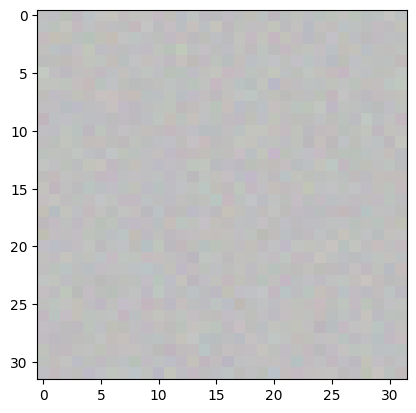

In [56]:
# Generate fake image
z = torch.randn(1, latent_dim)
fake_image = G(z)
fake_image = fake_images.view(fake_images.size(0), 3, 32, 32)
fake_image = (fake_images + 1) / 2  # Rescale images to [0, 1]
fake_image = fake_image.detach().numpy().reshape(32,32,3)
plt.imshow(fake_image)

The GAN does not generate a meaningful image. This may be due to undertraining due to runtime constraints.

Kalantar, R. (2023, November 22). Variational auto-encoder (VAE)-pytorch tutorial. Medium. https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

The Programming Geek. (2024b, January 29). Generating new realities: Crafting a simple gan with pytorch. Medium. https://medium.com/@theprogramminggeek/generating-new-realities-crafting-a-simple-gan-with-pytorch-fc312f57a12d

